# This is for matching the nearest road segment from shape file for a series of GPS points

In [1]:
from osgeo import ogr, gdalconst
import rtree
import os
import csv, json
import pandas as pd
from shapely.geometry import Point, mapping
from fiona import collection
from pandas.io.json import json_normalize
import numpy as np
import gmplot
import timeit
import ntpath
import shutil



def index_shape_file(shapefile):
    """
    This function is to geospatial index the shape file
    """
    driver = ogr.GetDriverByName('ESRI Shapefile')
    shapefiledata = driver.Open(shapefile, 0) # 0 means read-only. 1 means writeable.
    # Check to see if shapefile is found.
    if shapefiledata is None:
        print 'Could not open %s' % (shapefile)
        return None
    else:
        layer1 = shapefiledata.GetLayer()
        featureCount = layer1.GetFeatureCount()
        print "Number of features in %s: %d" % (os.path.basename(shapefile),featureCount)
        index = rtree.index.Index(interleaved=False)
        for fid1 in range(layer1.GetFeatureCount()):
            feature1 = layer1.GetFeature(fid1)
            geometry1 = feature1.GetGeometryRef()
            xmin, xmax, ymin, ymax = geometry1.GetEnvelope()
            index.insert(fid1, (xmin, xmax, ymin, ymax))
    return index, layer1, driver

In [2]:
#roadnetwork = './Ireland Opensource data/ireland-and-northern-ireland-latest-free.shp/gis.osm_roads_free_1.shp'
#gpsfile = "1294BFFE-AE75-4720-A146-A6AAE0BCBC84.201310140719350000.csv"
#gpsdata = pd.read_csv(gpsfile, index_col=False)
#gpsdata = gpsdata.ix[gpsdata.gps_lat.notnull()]
#gpsdata.dropna(axis=0, how='any', subset=['gps_lat', 'gps_lon'], inplace=True)

gpsfile = './test.json'
gpsfile_2shape_filename = os.path.splitext(ntpath.basename(gpsfile))[0]+"_zz"  # to use source file name

x_ = pd.read_json(gpsfile, orient="table")[['ROUTE']]
gpsdata = pd.DataFrame(x_)

# below is only to duplicate the data frame since we do not have
# trip data from Ireland yet
gpsdata = gpsdata.append(gpsdata)
gpsdata = gpsdata.append(gpsdata)
gpsdata = gpsdata.append(gpsdata)
gpsdata = gpsdata.append(gpsdata)
gpsdata = gpsdata.append(gpsdata)
gpsdata = gpsdata.append(gpsdata)
gpsdata = gpsdata.append(gpsdata)
gpsdata = gpsdata.append(gpsdata)
gpsdata['gps_lat'] = 0.0
gpsdata['gps_lon'] = 0.0
for index, row in x_.iterrows():
    #gpsdata.ix[index, 'gps_lat'] = test.ix[index]['ROUTE']['Latitude']
    #gpsdata.ix[index, 'gps_lon'] = test.ix[index]['ROUTE']['Longitude']
    gpsdata.ix[index, 'gps_lat'] = 53.3498
    gpsdata.ix[index, 'gps_lon'] = -6.2603

gpsdata.drop(['ROUTE'], axis=1, inplace=True)
print(gpsdata.shape)
gpsdata.head()

(60928, 2)


,gps_lat,gps_lon
0,53.3498,-6.2603
1,53.3498,-6.2603
2,53.3498,-6.2603
3,53.3498,-6.2603
4,53.3498,-6.2603


In [3]:
# Write GPS Data TO Shape File
schema = {'geometry': 'Point', 'properties': {'SITEID': 'str'}}

with collection(gpsfile_2shape_filename, "w", "ESRI Shapefile", schema) as output:
    for index, row in gpsdata.iterrows():
        point = Point(row['gps_lon'], row['gps_lat'])
        output.write({
            'properties': {'SITEID': index},
            'geometry': mapping(point)
        })

In [4]:
roadnetwork = './Ireland Opensource data/ireland-and-northern-ireland-latest-free.shp/gis.osm_roads_free_1.shp'

index, _ , driver = index_shape_file(roadnetwork)

Number of features in gis.osm_roads_free_1.shp: 514974


In [5]:
# Add road network layer
roadnetworkdata = driver.Open(roadnetwork, 0) 
layer1 = roadnetworkdata.GetLayer()  # layer1 from function index_shape_file can easily crash program, so need recreate

# Add GPS point layer
gpsfilepath = os.path.join("./", gpsfile_2shape_filename, gpsfile_2shape_filename+".shp")
pointfile = driver.Open(gpsfilepath, 0) # 0 means read-only. 1 means writeable.
layer2 = pointfile.GetLayer()

start_time = timeit.default_timer()

for fid2 in range(layer2.GetFeatureCount()):
    feature2 = layer2.GetFeature(fid2)
    geometry2 = feature2.GetGeometryRef()
    xmin, xmax, ymin, ymax = geometry2.Buffer(0.0007).GetEnvelope()
    min_dis = 1e+10
    best_fid = -1
    for fid1 in list(index.intersection((xmin, xmax, ymin, ymax))):
        feature1 = layer1.GetFeature(fid1)
        geometry1 = feature1.GetGeometryRef()
        #if geometry2.Buffer(0.0005).Intersects(geometry1):
            #print '{} intersects {}'.format(fid2, fid1)
            #print('Distance is {}'.format(geometry1.Distance(geometry2)))
        if geometry1.Distance(geometry2) < min_dis:
            min_dis = geometry1.Distance(geometry2)
            best_fid = fid1
    if fid2 < 10: print '{} intersects {}'.format(fid2, best_fid)  # just a print out of search result

elapsed = timeit.default_timer() - start_time
shutil.rmtree(gpsfile_2shape_filename)

0 intersects 67746
1 intersects 67746
2 intersects 67746
3 intersects 67746
4 intersects 67746
5 intersects 67746
6 intersects 67746
7 intersects 67746
8 intersects 67746
9 intersects 67746


In [6]:
lin_road = np.array(gpsdata.ix[0])
z=layer1.GetFeature(best_fid)
z2=z.GetGeometryRef()
z3=z2.GetPoints()

gmap = gmplot.GoogleMapPlotter(z.GetGeometryRef().GetY(), z.GetGeometryRef().GetX(), 16)
gmap.plot([lin_road[0][0]]*5, [lin_road[0][1]]*5, color = "blue", edge_width = 12)
gmap.plot([s1[1] for s1 in z3], [s2[0] for s2 in z3], color = "red", edge_width = 10)
gmap.draw("testfile_temp.html")

In [7]:
elapsed

51.234468936920166

## The following is the approach by using geopandas

In [8]:
import time
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame, read_file
from geopandas.tools import sjoin
from shapely.geometry import Point, mapping, shape


In [9]:
roadgdf = gpd.GeoDataFrame.from_file(roadnetwork)
roadgdf.head(5)

,bridge,code,fclass,geometry,layer,maxspeed,name,oneway,osm_id,ref,tunnel
0,F,5114,secondary,"LINESTRING (-6.2408699 53.3441505, -6.2408081 ...",0,50,Cardiff Lane,B,151364,R813,F
1,F,5114,secondary,"LINESTRING (-6.2635331 53.354535, -6.2634588 5...",0,30,Parnell Square East,F,151368,R132,F
2,F,5115,tertiary,"LINESTRING (-6.4445072 53.4016028, -6.4441885 ...",0,80,None,B,367947,L2223,F
3,F,5122,residential,"LINESTRING (-6.414479 53.386578, -6.41342 53.3...",0,50,Charnwood Avenue,B,367952,None,F
4,F,5115,tertiary,"LINESTRING (-6.4093775 53.3829633, -6.4094016 ...",0,50,Shelerin Road,B,508603,L3018,F


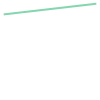

In [10]:
roadgdf.geometry[10]

In [11]:
gpsdata['geometry'] = gpsdata.apply(lambda x: Point(x.gps_lon, x.gps_lat), axis=1)
gpsdata = gpd.GeoDataFrame(gpsdata)
gpsdata.crs = roadgdf.crs
gpsdata.head()

,gps_lat,gps_lon,geometry
0,53.3498,-6.2603,POINT (-6.2603 53.3498)
1,53.3498,-6.2603,POINT (-6.2603 53.3498)
2,53.3498,-6.2603,POINT (-6.2603 53.3498)
3,53.3498,-6.2603,POINT (-6.2603 53.3498)
4,53.3498,-6.2603,POINT (-6.2603 53.3498)


In [12]:
print("Building Spatial Index for GeoPandas Data Frame...")
spatial_index = roadgdf.sindex

Building Spatial Index for GeoPandas Data Frame...


In [13]:
def shortest_distance(base,
                      ref,
                      base_latlong_col=["gps_lat", "gps_lon"],
                      ref_index = spatial_index,
                      buffer_size = 0.0007):
    # here base can geopandas data frame for points to be merged to
    # ref is the reference shape info, such as road network, etc.
    columns2add = np.setdiff1d(ref.columns.values, "geometry")
    fids_to_match = []
    ref_geometry = ref['geometry']
    if 'GeoDataFrame' in str(base.__class__):
        base = pd.DataFrame(base)
    longs = base[base_latlong_col[1]].values
    lats = base[base_latlong_col[0]].values
    for idx in range(base.shape[0]):
        row_gem = Point(longs[idx], lats[idx])
        fids = list(ref_index.intersection(row_gem.buffer(buffer_size).bounds))
        distances = map(lambda x: row_gem.distance(ref_geometry[x]), fids)
        if len(fids) > 0:
            best_id = fids[distances.index(min(distances))]  # best_id is fid in shape file
        fids_to_match += [best_id]
    x_ = pd.DataFrame(ref.iloc[fids_to_match][columns2add])
    x_.index = base.index
    base2 = pd.concat([base, x_], axis=1)
    return base2

In [14]:
start_time = timeit.default_timer()
res = shortest_distance(gpsdata, roadgdf)
elapsed = timeit.default_timer() - start_time

In [15]:
print(elapsed)
res.head()

83.7954359055


,gps_lat,gps_lon,geometry,bridge,code,fclass,layer,maxspeed,name,oneway,osm_id,ref,tunnel
0,53.3498,-6.2603,POINT (-6.2603 53.3498),F,5153,footway,0,0,None,B,42638929,None,F
1,53.3498,-6.2603,POINT (-6.2603 53.3498),F,5153,footway,0,0,None,B,42638929,None,F
2,53.3498,-6.2603,POINT (-6.2603 53.3498),F,5153,footway,0,0,None,B,42638929,None,F
3,53.3498,-6.2603,POINT (-6.2603 53.3498),F,5153,footway,0,0,None,B,42638929,None,F
4,53.3498,-6.2603,POINT (-6.2603 53.3498),F,5153,footway,0,0,None,B,42638929,None,F
